In [1]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import LabelEncoder
import os

In [2]:
def label_encode(event_list): 
    label_encoder = LabelEncoder()
    event_list = label_encoder.fit_transform(event_list)
    return event_list, label_encoder


In [3]:
# get current directory
data_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "data") 
pickle_file = open(data_path + "\\data.pckl", 'rb')
obj_arr = pickle.load(pickle_file)

#df_list is for training, val_df list for validation, test_df_list my own recorded data for testing
df_list, event_list, val_df_list, val_event_list, test_df_list, test_event_list = \
    obj_arr[0], obj_arr[1], obj_arr[2], obj_arr[3], obj_arr[4], obj_arr[5]


#create a mapping between event type strings and integer IDs to reduce RAM memory consumption
event_list, event_list_encoder = label_encode(event_list)
val_event_list, val_event_list_encoder = label_encode(val_event_list)
test_event_list, test_event_list_encoder = label_encode(test_event_list)



In [4]:
import random
random.seed(10)
np.random.seed(10)

def noise_injection(df, noise_factor=0.05): 
    """Adds noise to data for augmentation"""
    noise = np.random.randn(len(df["CH0"]))
    df["CH0"]  = df["CH0"] + noise_factor * noise
    return df

def pitch_change(df, sr=16000, n_steps=0):
    """Changes pitch of data, up or down one pitch per n_step"""
    df["CH0"] = librosa.effects.pitch_shift(np.asarray(df["CH0"]), sr=sr, n_steps=n_steps)
    return df

def augment(df): 
    """Augments a df with added noise and changed pitch"""
    noise_factor = random.randrange(0, 2, 1)/1000
    n_steps = random.randrange(-1, 1, 1)
    df = noise_injection(df, noise_factor=noise_factor)
    df = pitch_change(df, n_steps=n_steps)
    return df

for df in df_list: 
    df = augment(df)

In [5]:
def create_labeled_frames(df, nbr_of_frames, win_length, hop_length):
    """Processes label samples to become label frames, so labels match the format of the data after mfcc operation"""
    
    win_segments = librosa.frames_to_samples(np.arange(nbr_of_frames), hop_length=hop_length, n_fft=win_length)
    labeled_frames = np.zeros([nbr_of_frames, 1])
    
    #Iterate through samples, if more than 30% of labels in a frame are 1 (cough), then frame label becomes 1 as well, otherwise 0.  
    for i in range(len(labeled_frames)-1): 
        start = win_segments[i]
        end = win_segments[i+1]
        
        ratio = np.sum(df["label"][start:end])/(end-start)
        if ratio > 0.3: 
            labeled_frames[i] = 1
        else: 
            labeled_frames[i] = 0
    return labeled_frames

In [6]:
from spafe.features.gfcc import gfcc 
from spafe.features.lfcc import lfcc
from spafe.utils.preprocessing import SlidingWindow

def preprocess(df_list, event_list, sr=16000, n_mfcc=32):
    dataset = None
    dataset_temp = list()
        
    win_length = 0.032 #32 milliseconds window length, (23ms is librosa standard for speech processing). 512 samples total at 16kHz. 
    hop_length = 0.008
    #Sliding window for gfcc, had to use a different library as it is not supported in librosa
    window = SlidingWindow(win_len=win_length, win_hop=hop_length, win_type="hanning")
    
    for df, event in zip(df_list, event_list):
        mfcc = librosa.feature.mfcc(y=np.asarray(df["CH0"]), n_mfcc=n_mfcc, sr=sr, n_fft=int(win_length*sr), hop_length=int(hop_length*sr), center=False).T
        gfcc_coeffs = gfcc(np.asarray(df["CH0"]), fs=sr, num_ceps=n_mfcc, nfilts=n_mfcc, window=window)
        lfcc_coeffs = lfcc(np.asarray(df["CH0"]), fs=sr, num_ceps=n_mfcc, nfilts=n_mfcc, window=window)
        
        nbr_of_frames = mfcc.shape[0]
        labeled_frames = create_labeled_frames(df, nbr_of_frames, int(win_length*sr), int(hop_length*sr))
        event_frames = [event]* len(labeled_frames)
        event_frames = np.reshape(event_frames, (-1,1))
        data = np.concatenate((mfcc, lfcc_coeffs, gfcc_coeffs, labeled_frames, event_frames), axis=1)
        dataset_temp.append(data)
        
    dataset = np.concatenate(dataset_temp, axis=0)
                    
    return dataset
    


In [7]:
"""Create processed dataset, suitable for ann and tree-based learning"""

n_mfcc=32
dataset = preprocess(df_list, event_list, n_mfcc=n_mfcc)
val_dataset= preprocess(val_df_list, val_event_list, n_mfcc=n_mfcc)
test_dataset = preprocess(test_df_list, test_event_list, n_mfcc=n_mfcc)


In [8]:
# create batches for cnn learning
from collections import Counter

def most_common_string(lst):
    """Return most common element in array"""
    data = Counter(lst)
    return data.most_common(1)[0][0]

def create_image_batches(dataset, n_frames=32, n_coeffs=32):
    batch_labels = list()
    batch_list = list()
    event_list = list()
        
    for i in range(0, len(dataset)-n_frames, n_frames):
        batch=np.zeros((n_frames, n_coeffs, 3))
        batch[:,:,0] = dataset[i:i+n_frames, :n_coeffs] #MFCC 
        batch[:,:,1] = dataset[i:i+n_frames, n_coeffs:n_coeffs*2] #GFCC 
        batch[:,:,2] = dataset[i:i+n_frames, n_coeffs*2:-2] #LFCC

        labels = dataset[i:i+n_frames, -2].astype(float).astype(int) #Cast to int since they are str for some reason... 
        event_types = dataset[i:i+n_frames, -1]
        
        #At least 15% of batch samples need to be labeled cough for batch to be labeled as a cough batch
        cough_ratio = np.sum(labels)/n_frames
        if cough_ratio > 0.15:
            batch_list.append(batch)
            batch_labels.append(1)
            
        else: 
            batch_list.append(batch)
            batch_labels.append(0)
            
        #append event type to event list, if two event types are present, append the most frequently occurring one
        event_list.append(most_common_string(event_types))
        
    return batch_list, batch_labels, event_list

In [9]:
n_frames=32 #shape 1 for CNN input
n_mfcc = 32 #shape 2 for CNN input
#3 channels (mfcc, gfcc, lfcc) makes the input 32x32x3

dataset_batch, label_batch, event_type_batch = create_image_batches(dataset, n_frames=n_frames, n_coeffs=n_mfcc)

val_dataset_batch, val_label_batch, val_event_type_batch = \
    create_image_batches(val_dataset, n_frames=n_frames, n_coeffs=n_mfcc)

test_dataset_batch, test_label_batch, test_event_type_batch = \
    create_image_batches(test_dataset, n_frames=n_frames, n_coeffs=n_mfcc)

#Convert lists to numpy arrays for CNN model
dataset_batch = np.asarray(dataset_batch)
label_batch = np.asarray(label_batch)
val_dataset_batch = np.asarray(val_dataset_batch)
val_label_batch = np.asarray(val_label_batch)
val_event_type_batch = np.asarray(val_event_type_batch)
test_dataset_batch = np.asarray(test_dataset_batch)
test_label_batch = np.asarray(test_label_batch)
test_event_type_batch = np.asarray(test_event_type_batch)


In [10]:
import keras
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras import Sequential
from keras.metrics import Recall, Precision

from sklearn.model_selection import train_test_split
from keras.utils import set_random_seed
from keras.regularizers import L1
from keras.callbacks import ReduceLROnPlateau
set_random_seed(10)

X_train, X_test, Y_train, Y_test = train_test_split(dataset_batch, label_batch, test_size=0.03, random_state=0, shuffle=True)

model = Sequential()
model.add(BatchNormalization())
model.add(Conv2D(4, kernel_size=(2, 2), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(4, kernel_size=(2, 2), activation='relu'))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(), Precision()])

checkpoint_filepath = data_path + "\\weigths" 

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.6,
    patience=2,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(X_train, Y_train, epochs = 15, validation_data=[val_dataset_batch, val_label_batch], callbacks=[model_checkpoint_callback, reduce_lr])


Epoch 1/15
327/327 [==============================] - 14s 32ms/step - loss: 0.2968 - accuracy: 0.8864 - recall: 0.5318 - precision: 0.7841 - val_loss: 0.1759 - val_accuracy: 0.9288 - val_recall: 0.3580 - val_precision: 0.9265 - lr: 0.0010
Epoch 2/15
327/327 [==============================] - 9s 26ms/step - loss: 0.2135 - accuracy: 0.9250 - recall: 0.7036 - precision: 0.8657 - val_loss: 0.2011 - val_accuracy: 0.9487 - val_recall: 0.8182 - val_precision: 0.7310 - lr: 0.0010
Epoch 3/15
327/327 [==============================] - 8s 23ms/step - loss: 0.1931 - accuracy: 0.9302 - recall: 0.7382 - precision: 0.8643 - val_loss: 0.1454 - val_accuracy: 0.9590 - val_recall: 0.7216 - val_precision: 0.8699 - lr: 0.0010
Epoch 4/15
327/327 [==============================] - 9s 27ms/step - loss: 0.1844 - accuracy: 0.9329 - recall: 0.7434 - precision: 0.8746 - val_loss: 0.2212 - val_accuracy: 0.9384 - val_recall: 0.8636 - val_precision: 0.6609 - lr: 0.0010
Epoch 5/15
327/327 [===========================

In [11]:
model.load_weights(data_path + "\\weigths" )

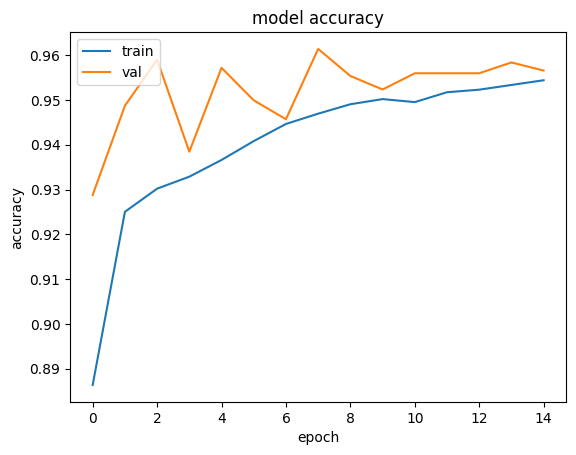

In [12]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

2/2 [==============================] - 0s 4ms/step
Accuracy: 0.8181818127632141, Recall: 0.6842105388641357, Precision: 1.0


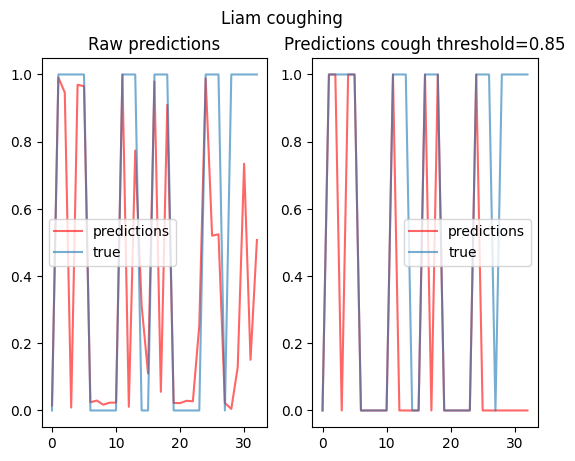

In [13]:
"""Predictions on Liam coughs"""
import matplotlib.pyplot as plt 

test_event_type_batch_decoded = test_event_list_encoder.inverse_transform(test_event_type_batch.astype(int))

cough_indexes = [i for i in range(len(test_event_type_batch_decoded)) if "cough" in test_event_type_batch_decoded[i]]
liam_cough_data = test_dataset_batch[cough_indexes]
liam_cough_labels = test_label_batch[cough_indexes]

threshold=0.85

predictions = model.predict(liam_cough_data)
predict_binary = (predictions>threshold).astype(int)
Y = np.reshape(liam_cough_labels, (-1, 1))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(predictions, alpha=0.6, color='r')
ax1.plot(Y, alpha=0.6)
ax1.legend(["predictions", "true"])
ax1.set_title("Raw predictions")

ax2.plot(predict_binary, alpha=0.6, color='r')
ax2.plot(Y, alpha=0.6)
ax2.set_title("Predictions cough threshold={}".format(threshold))
ax2.legend(["predictions", "true"])
plt.suptitle("Liam coughing")
loss, accuracy, recall, precision  = model.evaluate(liam_cough_data, liam_cough_labels, verbose=0)
print("Accuracy: {}, Recall: {}, Precision: {}".format(accuracy, recall, precision)) 

4/4 [==============================] - 0s 5ms/step
Accuracy: 0.9661017060279846, Recall: 0.0, Precision: 0.0


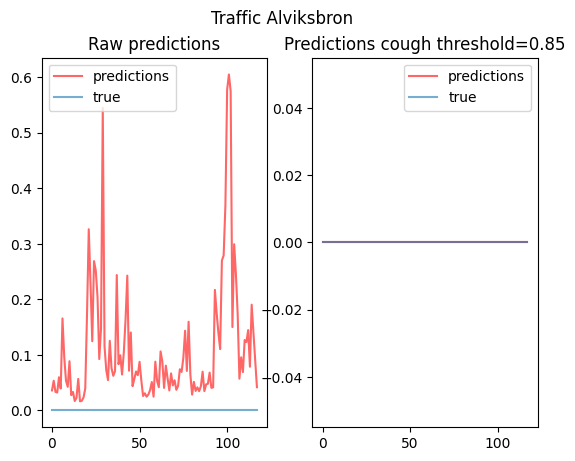

In [14]:
""" Predictions on easy case: Traffic on Alviksbron """ 
import matplotlib.pyplot as plt 

traffic_indexes = [i for i in range(len(test_event_type_batch_decoded)) if "Traffic" in test_event_type_batch_decoded[i]]
traffic_data = test_dataset_batch[traffic_indexes]
traffic_labels = test_label_batch[traffic_indexes]

predictions = model.predict(traffic_data)
predict_binary = (predictions>threshold).astype(int)
Y = np.reshape(traffic_labels, (-1, 1))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(predictions, alpha=0.6, color='r')
ax1.plot(Y, alpha=0.6)
ax1.legend(["predictions", "true"])
ax1.set_title("Raw predictions")

ax2.plot(predict_binary, alpha=0.6, color='r')
ax2.plot(Y, alpha=0.6)
ax2.set_title("Predictions cough threshold={}".format(threshold))
ax2.legend(["predictions", "true"])
plt.suptitle("Traffic Alviksbron")
loss, accuracy, recall, precision  = model.evaluate(traffic_data, traffic_labels, verbose=0)
print("Accuracy: {}, Recall: {}, Precision: {}".format(accuracy, recall, precision)) 

9/9 [==============================] - 0s 6ms/step
Accuracy: 0.5183823704719543, Recall: 0.0, Precision: 0.0


' poor results, retraining with dog bark data is necessary '

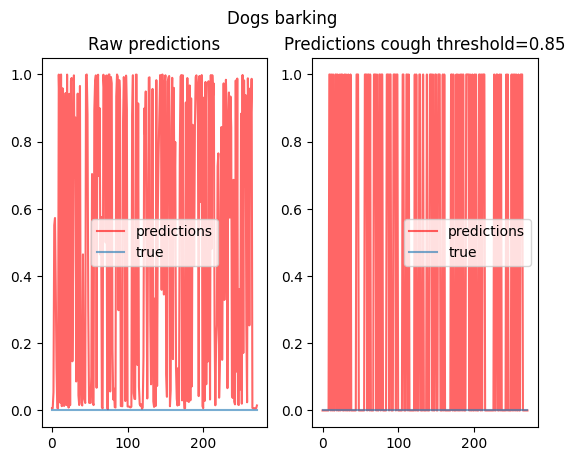

In [15]:
"Predictions on hard case, dogs barking"
import matplotlib.pyplot as plt 

dog_indexes = [i for i in range(len(test_event_type_batch_decoded)) if "dog" in test_event_type_batch_decoded[i]]
dog_data = test_dataset_batch[dog_indexes]
dog_labels = test_label_batch[dog_indexes]

predictions = model.predict(dog_data)
predict_binary = (predictions>threshold).astype(int)
Y = np.reshape(dog_labels, (-1, 1))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(predictions, alpha=0.6, color='r')
ax1.plot(Y, alpha=0.6)
ax1.legend(["predictions", "true"])
ax1.set_title("Raw predictions")

ax2.plot(predict_binary, alpha=0.6, color='r')
ax2.plot(Y, alpha=0.6)
ax2.set_title("Predictions cough threshold={}".format(threshold))
ax2.legend(["predictions", "true"])
plt.suptitle("Dogs barking")
loss, accuracy, recall, precision  = model.evaluate(dog_data, dog_labels, verbose=0)
print("Accuracy: {}, Recall: {}, Precision: {}".format(accuracy, recall, precision)) 

""" poor results, retraining with dog bark data is necessary """


52/52 [==============================] - 0s 6ms/step
Accuracy: 0.9613759517669678, Recall: 0.8352272510528564, Precision: 0.807692289352417


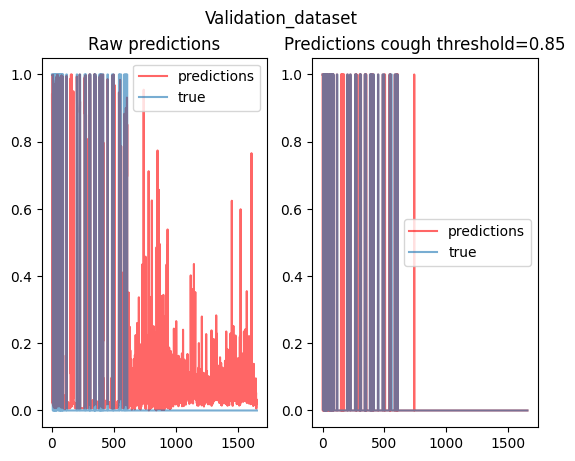

In [16]:
"#Predictions on validation dataset"
import matplotlib.pyplot as plt 

predictions = model.predict(val_dataset_batch)
predict_binary = (predictions>threshold).astype(int)
Y = np.reshape(val_label_batch, (-1, 1))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(predictions, alpha=0.6, color='r')
ax1.plot(Y, alpha=0.6)
ax1.legend(["predictions", "true"])
ax1.set_title("Raw predictions")

ax2.plot(predict_binary, alpha=0.6, color='r')
ax2.plot(Y, alpha=0.6)
ax2.set_title("Predictions cough threshold={}".format(threshold))
ax2.legend(["predictions", "true"])
plt.suptitle("Validation_dataset")
loss, accuracy, recall, precision  = model.evaluate(val_dataset_batch, val_label_batch, verbose=0)
print("Accuracy: {}, Recall: {}, Precision: {}".format(accuracy, recall, precision)) 
